# DQN Implementation

## Imports

In [1]:
import numpy as np
import time
from IPython.display import clear_output

import pickle

from envs import game2048_env

from tqdm import tqdm

from itertools import product

id_action_dict = {0 : "UP",
                  1 : "RIGHT",
                  2 : "DOWN",
                  3 : "LEFT"}

In [2]:
from torch import nn
import torch
from collections import deque
import itertools
import random
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [3]:
if torch.cuda.is_available():
    device = "cuda:0"
elif torch.backends.mps.is_available():
    device = "mps" # "mps"
else:
    device = "cpu"
    
device = torch.device(device)
    
print("PyTorch is using :", device)

PyTorch is using : mps


## Neural network

We first define the neural network architecture that we will use for the agent.

In [4]:
class DQN(nn.Module):
    ### Deep Q-Learning Network
    def __init__(self):
        super(DQN, self).__init__()
        
        input_depth = 11
        
        self.conv_a = nn.Conv2d(input_depth, 128, kernel_size=(1,2))       # Convolutional layers
        self.conv_b = nn.Conv2d(input_depth, 128, kernel_size=(2,1))

        self.conv_aa = nn.Conv2d(128, 128, kernel_size=(1,2))
        self.conv_ab = nn.Conv2d(128, 128, kernel_size=(2,1))

        self.conv_ba = nn.Conv2d(128, 128, kernel_size=(1,2))
        self.conv_bb = nn.Conv2d(128, 128, kernel_size=(2,1))
        
        self.fc = nn.Sequential(         # Linear and Relu
            nn.Linear(7424, 256),
            nn.ReLU(),
            nn.Linear(256, 4)
        )
        
    def forward(self, x):
        # Forward function of the layer
        x_a = F.relu(self.conv_a(x))
        x_b = F.relu(self.conv_b(x))
        
        x_aa = F.relu(self.conv_aa(x_a))
        x_ab = F.relu(self.conv_ab(x_a))
        
        x_ba = F.relu(self.conv_ba(x_b))
        x_bb = F.relu(self.conv_bb(x_b))
        
        sh_a = x_a.shape
        sh_aa = x_aa.shape
        sh_ab = x_ab.shape
        sh_b = x_b.shape
        sh_ba = x_ba.shape
        sh_bb = x_bb.shape
        
        x_a = x_a.view(sh_a[0],sh_a[1]*sh_a[2]*sh_a[3])
        x_aa = x_aa.view(sh_aa[0],sh_aa[1]*sh_aa[2]*sh_aa[3])
        x_ab = x_ab.view(sh_ab[0],sh_ab[1]*sh_ab[2]*sh_ab[3])
        x_b = x_b.view(sh_b[0],sh_b[1]*sh_b[2]*sh_b[3])
        x_ba = x_ba.view(sh_ba[0],sh_ba[1]*sh_ba[2]*sh_ba[3])
        x_bb = x_bb.view(sh_bb[0],sh_bb[1]*sh_bb[2]*sh_bb[3])
        
        concat = torch.cat((x_a,x_b,x_aa,x_ab,x_ba,x_bb),dim=1)
        
        output = self.fc(concat)
        
        return output
    
    def act(self, obs):
        obs_t = torch.as_tensor(obs, dtype=torch.float32)
        q_values = self(obs_t.unsqueeze(0))
        
        max_q_index = torch.argmax(q_values, dim=1)[0]
        
        action = max_q_index.detach().item()
        
        return action

## Training

We then define a `class` for the agent, that will incorporate all the methods.

In [5]:
class DQN_Agent():
    def __init__(self,
                 gamma=0.99,
                 batch_size = 16,
                 buffer_size = 50000,
                 min_replay_size = 1000,
                 epsilon_start = 1,
                 epsilon_end = 0.0001,
                 epsilon_decay = 10000,
                 target_update_freq = 10,
                 learning_rate = 1e-4,
                 update_type="hard",
                 tau=0.001):
        
        self.GAMMA = gamma
        self.BATCH_SIZE = batch_size
        self.BUFFER_SIZE = buffer_size
        self.MIN_REPLAY_SIZE = min_replay_size
        self.EPSILON_START = epsilon_start
        self.EPSILON_END = epsilon_end
        self.EPSILON_DECAY = epsilon_decay
        
        self.epsilon = self.EPSILON_START
        
        self.step_count = 0
        
        self.TARGET_UPDATE_FREQ = 10
        self.update_type = update_type
        self.tau = tau
        
        self.LEARNING_RATE = learning_rate
        
        self.env = game2048_env.Game2048Env()
        
        self.replay_buffer = deque(maxlen=self.BUFFER_SIZE)
        self.rew_buffer = deque(maxlen=100)
        self.highest_buffer = deque(maxlen=100)
        
        if torch.cuda.is_available():
            device = "cuda"
        elif torch.backends.mps.is_available():
            device = "mps"
        else:
            device = "cpu"
        
        self.device = torch.device(device)
        
        
        self.online_net = DQN().to(device)
        self.target_net = DQN().to(device)
        
        self.target_net.load_state_dict(self.online_net.state_dict())
        
        self.optimizer = torch.optim.Adam(self.online_net.parameters(), lr=self.LEARNING_RATE)
        
        self.train_reward_history = []
        self.train_high_history = []
        self.train_loss_history = []

        self.play_high = 0

        self.train_play_high_history = []

    
    def _transform_observation(self, obs):
        obs = np.rollaxis(obs, 2)[:11]
        obs = np.flip(obs, axis=0)
        return obs.copy()
    
    def _transform_reward(self, obs, rew, info):
        
        #if info['illegal_move'] == True:
        #    rew = - 1
        
        #if rew > 0:
            #rew = rew
        
        # Number of full squares penalty
        rew = (16 - np.sum(obs)) / 2
        
        return rew
        
    
    def populate_buffer(self):
        obs = self.env.reset()
        obs = self._transform_observation(obs)
        
        for _ in range(self.MIN_REPLAY_SIZE):
            action = self.env.action_space.sample()

            new_obs, rew, done, info = self.env.step(action)
            rew = self._transform_reward(new_obs, rew, info)
            new_obs = self._transform_observation(new_obs)
            
            transition = (obs, action, rew, done, new_obs)
            self.replay_buffer.append(transition)
            obs = new_obs
    
            if done:
                obs = self.env.reset()
                obs = self._transform_observation(obs)
    
    
    def save_model(self):
        format = f"{self.update_type}_bs={self.BATCH_SIZE}_gamma={self.GAMMA}_lr={self.LEARNING_RATE}_eps={self.EPSILON_START}_decay={self.EPSILON_DECAY}"
        
        online_path = "online_" + format
        torch.save(self.online_net, online_path)
        
        target_path = "target_" + format
        torch.save(self.target_net, target_path)

        print("Format :\n")
        print(format)

        print("Model saved !")
        
        
    def load_model(self, path_format=None):

        if path_format is None:
            path_format = f"{self.update_type}_bs={self.BATCH_SIZE}_gamma={self.GAMMA}_lr={self.LEARNING_RATE}_eps={self.EPSILON_START}_decay={self.EPSILON_DECAY}"
        
        online_path = "online_" + path_format
        self.online_net = torch.load(online_path)
        
        target_path = "target_" + path_format
        self.target_net = torch.load(target_path)

        print("Model loaded !")
    
    
    def epoch(self):
        obs = self.env.reset()
        obs = self._transform_observation(obs)
        
        episode_reward = 0
        
        done = False
        
        
        while not done:
            
            self.step_count += 1
            
            
            # Epsilon Greedy Policy
            rnd_sample = np.random.random()
    
            if rnd_sample <= self.epsilon:
                action = self.env.action_space.sample()
                new_obs, rew, done, info = self.env.step(action)
                rew = self._transform_reward(new_obs, rew, info)
                new_obs = self._transform_observation(new_obs)
            else:
                obs_t = torch.as_tensor(obs, dtype=torch.float32).to(self.device)
                predicted_q_values = self.online_net.forward(obs_t.unsqueeze(0))
                
                best_performers = predicted_q_values.argsort()[0].cpu().numpy()[::-1]
                
                action = self.online_net.act(torch.as_tensor(obs, dtype=torch.float32).to(self.device))
                new_obs, rew, done, info = self.env.step(action)
                rew = self._transform_reward(new_obs, rew, info)
                new_obs = self._transform_observation(new_obs)
            
                if np.array_equal(new_obs, obs):
                    for action in best_performers[1:]:
                        # When the agent selects a move that can't change the state of the cells, so it loops infinitely
                        # We select an action other than the one corresponding to max-Q in Q-decreasing order
                        obs = new_obs
                        new_obs, rew, done, info = self.env.step(action)
                        rew = self._transform_reward(new_obs, rew, info)
                        new_obs = self._transform_observation(new_obs)

                        if not np.array_equal(new_obs, obs):
                            break
            
            
            transition = (obs, action, rew, done, new_obs)
            obs = new_obs
            
            #print(obs.shape)
            
            self.replay_buffer.append(transition)
            
            episode_reward += rew
            
            # Update Target Network
            if (self.update_type == "hard") and (self.step_count % self.TARGET_UPDATE_FREQ == 0):
                self.target_net.load_state_dict(self.online_net.state_dict())
            elif self.update_type == "soft":
                target_net_state_dict = self.target_net.state_dict()
                online_net_state_dict = self.online_net.state_dict()
                for key in online_net_state_dict:
                    target_net_state_dict[key] = online_net_state_dict[key] * self.tau + target_net_state_dict[key]*(1-self.tau)
                self.target_net.load_state_dict(target_net_state_dict)
            
            
            if self.step_count % 1 == 0:
                # Start Gradient Step
                transitions = random.sample(self.replay_buffer, self.BATCH_SIZE)

                obses = np.asarray([t[0] for t in transitions])
                actions = np.asarray([t[1] for t in transitions])
                rews = np.asarray([t[2] for t in transitions])
                dones = np.asarray([t[3] for t in transitions])
                new_obses = np.asarray([t[4] for t in transitions])

                obses_t = torch.as_tensor(obses, dtype=torch.float32).squeeze(1).to(self.device)
                actions_t = torch.as_tensor(actions, dtype=torch.int64).unsqueeze(1).to(self.device)
                rews_t = torch.as_tensor(rews, dtype=torch.float32).unsqueeze(1).to(self.device)
                dones_t = torch.as_tensor(dones, dtype=torch.float32).unsqueeze(1).to(self.device)
                new_obses_t = torch.as_tensor(new_obses, dtype=torch.float32).squeeze(1).to(self.device)

                # Compute targets
                with torch.no_grad():
                    target_q_values = self.target_net(new_obses_t)
                    max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]

                targets = rews_t + self.GAMMA * (1 - dones_t) * max_target_q_values

                # Compute Loss
                q_values = self.online_net(obses_t)

                action_q_values = torch.gather(input=q_values, dim=1, index=actions_t)

                loss = nn.functional.mse_loss(action_q_values, targets)
                
                # Gradient Descent
                self.optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_value_(self.online_net.parameters(), 100)   # Gradient clipping
                self.optimizer.step()
            
            self.train_loss_history.append(loss.detach().cpu().numpy().item())


            if done:
                obs = self.env.reset()
                obs = self._transform_observation(obs)

                self.rew_buffer.append(episode_reward)
                self.highest_buffer.append(info['highest'])
                
                #print("Epsilon :", self.epsilon)

        epsilon_step = (self.EPSILON_START - self.EPSILON_END) / self.EPSILON_DECAY
        self.epsilon = max(self.epsilon - epsilon_step, self.EPSILON_END)
    
        #print(self.epsilon)
            
        return episode_reward, info['highest'], loss.detach().cpu().numpy().item()
            
    
    def train(self, n_epochs, verbose=True, save_model=True, play_epoch=100):
        
        if len(self.replay_buffer) < self.MIN_REPLAY_SIZE:
            if verbose:
                print("Filling the buffer...")
            self.populate_buffer()
        
        if verbose:
            print("Start training")
            print("-" * 100)
        
        reward_history = []
        high_history = []
        loss_history = []
        
        for epoch in tqdm(range(n_epochs), disable=True):
            rew_buffer, highest_buffer, loss = self.epoch()
            
            loss_history.append(loss)
            
            avg_rew = int(np.mean(rew_buffer))
            avg_high = int(np.mean(highest_buffer))
            avg_loss = np.round(np.mean(loss), 1)
            
            self.train_reward_history.append(avg_rew)
            self.train_high_history.append(avg_high)

            if verbose:
                print(f"Epoch {epoch+1}/{n_epochs} : reward = {avg_rew}, highest value = {avg_high}")

            if (epoch + 1) % play_epoch == 0: 
                average_high_play = 0
                average_high_play_log = 0
                n_plays = 20
                for _ in range(n_plays):
                    self = self.play(False)
                    average_high_play_log += np.log2(self.play_high) / n_plays
                    average_high_play += self.play_high / n_plays
                
                self.train_play_high_history.append(average_high_play)

                print("-" * 70)
                print("Average of log2(high) while playing :", np.round(average_high_play_log, 2))
                print("Average of high while playing :", np.round(average_high_play, 1))
                print("-" * 70)
        
        print('_' * 100)
        print("Training ended !")
        print('_' * 100)

        if save_model:
            self.save_model()
        
        return agent
            
    
    def play(self, render=True):
        
        obs = self.env.reset()
        obs = self._transform_observation(obs)
        
        self.play_high = 0
        
        done = False
        
        while not done:
            obs_t = torch.as_tensor(obs, dtype=torch.float32).to(self.device)
            predicted_q_values = self.online_net.forward(obs_t.unsqueeze(0))

            best_performers = predicted_q_values.argsort()[0].cpu().numpy()[::-1]

            action = self.online_net.act(torch.as_tensor(obs, dtype=torch.float32).to(self.device))
            new_obs, rew, done, info = self.env.step(action)
            #rew = self._transform_reward(new_obs, rew)
            new_obs = self._transform_observation(new_obs)
                

            if np.array_equal(new_obs, obs):
                for action in best_performers[1:]:
                    # When the agent selects a move that can't change the state of the cells, so it loops infinitely
                    # We select an action other than the one corresponding to max-Q in Q-decreasing order
                    obs = new_obs
                    new_obs, rew, done, info = self.env.step(action)
                    rew = self._transform_reward(new_obs, rew, info)
                    new_obs = self._transform_observation(new_obs)

                    if not np.array_equal(new_obs, obs):
                        break
            else:
                obs = new_obs
            
            if render:
                clear_output(wait=True)
                
                self.env.render('human')
            
            if done:
                self.play_high = info["highest"]
        
        return self
        
            

### Hyperparameter tuning

In [ ]:
batch_size_values = [32]
epsilon_start_values = [0.1, 0.3]
epsilon_decay_values = [600]
update_type_values = ['hard', 'soft']

tau_values = [0.01, 0.001, 0.005]
target_update_freq_values = [5, 10, 20]

combinations = product(batch_size_values,
                       epsilon_start_values,
                       epsilon_decay_values,
                       update_type_values)

combinations = list(combinations)

n_train_episodes = 500

n_total = len(list(combinations)) * 3

i = 0

dict_agents = dict()


for combination in combinations:
    batch_size, epsilon_start, epsilon_decay, update_type = combination

    if update_type == 'soft':
        for tau in tau_values:
            i += 1
            print(f"Combination {i} / {n_total} :")
            print(combination)
            print("tau =", tau)
            agent = DQN_Agent(gamma=gamma,
                            batch_size=batch_size,
                            buffer_size=buffer_size,
                            min_replay_size=min_replay_size,
                            epsilon_start=epsilon_start,
                            epsilon_end=epsilon_end,
                            epsilon_decay=epsilon_decay,
                            target_update_freq=target_update_freq,
                            learning_rate=learning_rate,
                            update_type=update_type,
                            tau=tau)
            
            agent = agent.train(n_train_episodes, verbose=False, save_model=False, play_epoch=n_train_episodes)

            list_combi = list(combination)
            dict_key = list_combi + [tau]
            dict_agents[dict_key] = agent

            print("-" * 70)

            
    if update_type == 'hard':
        for target_update_freq in target_update_freq_values:
            i += 1
            print(f"Combination {i} / {n_total} :")
            print(combination)
            print("target_update_fred =", target_update_freq)
            agent = DQN_Agent(gamma=gamma,
                            batch_size=batch_size,
                            buffer_size=buffer_size,
                            min_replay_size=min_replay_size,
                            epsilon_start=epsilon_start,
                            epsilon_end=epsilon_end,
                            epsilon_decay=epsilon_decay,
                            target_update_freq=target_update_freq,
                            learning_rate=learning_rate,
                            update_type=update_type,
                            tau=tau)
            
            agent = agent.train(n_train_episodes, verbose=False, save_model=False, play_epoch=n_train_episodes)

            list_combi = list(combination)
            dict_key = list_combi + [target_update_freq]
            dict_agents[dict_key] = agent

            print("-" * 70)

In [99]:
with open('dict_agents_hyperparameter.pickle', 'wb') as file:
    pickle.dump(dict_agents, file, protocol=pickle.HIGHEST_PROTOCOL)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The combination that was the best on the first 500 epochs was BY FAR :

(32, 0.3, 600, 'soft') with tau = 0.001

We will therefore use it in the subsequent training.

Let's first plot the rewards and the scores for the hyperparameter combinations : 

In [101]:
with open('dict_agents_hyperparameter.pickle', 'rb') as file:
    dict_test = pickle.load(file)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Training the agent

We now train the model on the following parameters and see how it performs :

In [6]:
gamma = 0.99
batch_size = 64
buffer_size = 100000
min_replay_size = batch_size * 10
epsilon_start = 0.2
epsilon_end = 1e-3
epsilon_decay = 750
target_update_freq = 50
learning_rate = 1e-4
update_type = "soft"
tau = 1e-3


agent = DQN_Agent(gamma=gamma,
                  batch_size=batch_size,
                  buffer_size=buffer_size,
                  min_replay_size=min_replay_size,
                  epsilon_start=epsilon_start,
                  epsilon_end=epsilon_end,
                  epsilon_decay=epsilon_decay,
                  target_update_freq=target_update_freq,
                  learning_rate=learning_rate,
                  update_type=update_type,
                  tau=tau)


In [7]:
n_training_episodes = 2900

agent.train(n_training_episodes)

Filling the buffer...
Start training
----------------------------------------------------------------------------------------------------
Epoch 1/2900 : reward = 308, highest value = 64
Epoch 2/2900 : reward = 245, highest value = 64
Epoch 3/2900 : reward = 344, highest value = 128
Epoch 4/2900 : reward = 332, highest value = 128
Epoch 5/2900 : reward = 346, highest value = 256
Epoch 6/2900 : reward = 416, highest value = 128
Epoch 7/2900 : reward = 264, highest value = 64
Epoch 8/2900 : reward = 281, highest value = 128
Epoch 9/2900 : reward = 360, highest value = 128
Epoch 10/2900 : reward = 307, highest value = 128
Epoch 11/2900 : reward = 338, highest value = 128
Epoch 12/2900 : reward = 344, highest value = 128
Epoch 13/2900 : reward = 446, highest value = 128
Epoch 14/2900 : reward = 278, highest value = 64
Epoch 15/2900 : reward = 371, highest value = 128
Epoch 16/2900 : reward = 410, highest value = 128
Epoch 17/2900 : reward = 411, highest value = 256
Epoch 18/2900 : reward = 

Epoch 158/2900 : reward = 538, highest value = 256
Epoch 159/2900 : reward = 504, highest value = 128
Epoch 160/2900 : reward = 487, highest value = 256
Epoch 161/2900 : reward = 463, highest value = 128
Epoch 162/2900 : reward = 689, highest value = 256
Epoch 163/2900 : reward = 457, highest value = 128
Epoch 164/2900 : reward = 603, highest value = 256
Epoch 165/2900 : reward = 494, highest value = 128
Epoch 166/2900 : reward = 826, highest value = 512
Epoch 167/2900 : reward = 387, highest value = 128
Epoch 168/2900 : reward = 763, highest value = 256
Epoch 169/2900 : reward = 936, highest value = 512
Epoch 170/2900 : reward = 282, highest value = 64
Epoch 171/2900 : reward = 509, highest value = 128
Epoch 172/2900 : reward = 782, highest value = 256
Epoch 173/2900 : reward = 353, highest value = 128
Epoch 174/2900 : reward = 609, highest value = 256
Epoch 175/2900 : reward = 455, highest value = 128
Epoch 176/2900 : reward = 505, highest value = 256
Epoch 177/2900 : reward = 574, h

Epoch 311/2900 : reward = 848, highest value = 512
Epoch 312/2900 : reward = 609, highest value = 256
Epoch 313/2900 : reward = 425, highest value = 128
Epoch 314/2900 : reward = 321, highest value = 64
Epoch 315/2900 : reward = 431, highest value = 128
Epoch 316/2900 : reward = 644, highest value = 256
Epoch 317/2900 : reward = 723, highest value = 256
Epoch 318/2900 : reward = 648, highest value = 256
Epoch 319/2900 : reward = 542, highest value = 256
Epoch 320/2900 : reward = 428, highest value = 128
Epoch 321/2900 : reward = 442, highest value = 128
Epoch 322/2900 : reward = 537, highest value = 256
Epoch 323/2900 : reward = 730, highest value = 256
Epoch 324/2900 : reward = 612, highest value = 256
Epoch 325/2900 : reward = 409, highest value = 128
Epoch 326/2900 : reward = 749, highest value = 256
Epoch 327/2900 : reward = 432, highest value = 128
Epoch 328/2900 : reward = 533, highest value = 256
Epoch 329/2900 : reward = 430, highest value = 128
Epoch 330/2900 : reward = 847, h

Epoch 468/2900 : reward = 502, highest value = 128
Epoch 469/2900 : reward = 935, highest value = 512
Epoch 470/2900 : reward = 714, highest value = 256
Epoch 471/2900 : reward = 640, highest value = 256
Epoch 472/2900 : reward = 453, highest value = 128
Epoch 473/2900 : reward = 902, highest value = 512
Epoch 474/2900 : reward = 720, highest value = 256
Epoch 475/2900 : reward = 729, highest value = 512
Epoch 476/2900 : reward = 583, highest value = 128
Epoch 477/2900 : reward = 645, highest value = 256
Epoch 478/2900 : reward = 881, highest value = 512
Epoch 479/2900 : reward = 723, highest value = 256
Epoch 480/2900 : reward = 654, highest value = 256
Epoch 481/2900 : reward = 703, highest value = 256
Epoch 482/2900 : reward = 602, highest value = 256
Epoch 483/2900 : reward = 1092, highest value = 512
Epoch 484/2900 : reward = 706, highest value = 256
Epoch 485/2900 : reward = 679, highest value = 256
Epoch 486/2900 : reward = 521, highest value = 256
Epoch 487/2900 : reward = 335,

Epoch 620/2900 : reward = 673, highest value = 256
Epoch 621/2900 : reward = 566, highest value = 256
Epoch 622/2900 : reward = 450, highest value = 128
Epoch 623/2900 : reward = 554, highest value = 256
Epoch 624/2900 : reward = 532, highest value = 128
Epoch 625/2900 : reward = 991, highest value = 512
Epoch 626/2900 : reward = 508, highest value = 128
Epoch 627/2900 : reward = 1094, highest value = 512
Epoch 628/2900 : reward = 359, highest value = 64
Epoch 629/2900 : reward = 777, highest value = 256
Epoch 630/2900 : reward = 416, highest value = 128
Epoch 631/2900 : reward = 661, highest value = 256
Epoch 632/2900 : reward = 686, highest value = 256
Epoch 633/2900 : reward = 666, highest value = 256
Epoch 634/2900 : reward = 717, highest value = 256
Epoch 635/2900 : reward = 771, highest value = 256
Epoch 636/2900 : reward = 626, highest value = 256
Epoch 637/2900 : reward = 442, highest value = 128
Epoch 638/2900 : reward = 660, highest value = 256
Epoch 639/2900 : reward = 612, 

Epoch 776/2900 : reward = 949, highest value = 512
Epoch 777/2900 : reward = 731, highest value = 256
Epoch 778/2900 : reward = 922, highest value = 512
Epoch 779/2900 : reward = 726, highest value = 512
Epoch 780/2900 : reward = 929, highest value = 512
Epoch 781/2900 : reward = 446, highest value = 128
Epoch 782/2900 : reward = 598, highest value = 256
Epoch 783/2900 : reward = 660, highest value = 256
Epoch 784/2900 : reward = 609, highest value = 256
Epoch 785/2900 : reward = 692, highest value = 256
Epoch 786/2900 : reward = 482, highest value = 128
Epoch 787/2900 : reward = 717, highest value = 256
Epoch 788/2900 : reward = 1002, highest value = 512
Epoch 789/2900 : reward = 973, highest value = 512
Epoch 790/2900 : reward = 797, highest value = 256
Epoch 791/2900 : reward = 1245, highest value = 512
Epoch 792/2900 : reward = 1212, highest value = 512
Epoch 793/2900 : reward = 715, highest value = 256
Epoch 794/2900 : reward = 897, highest value = 512
Epoch 795/2900 : reward = 69

Epoch 927/2900 : reward = 966, highest value = 512
Epoch 928/2900 : reward = 1525, highest value = 1024
Epoch 929/2900 : reward = 600, highest value = 256
Epoch 930/2900 : reward = 459, highest value = 128
Epoch 931/2900 : reward = 532, highest value = 128
Epoch 932/2900 : reward = 607, highest value = 256
Epoch 933/2900 : reward = 779, highest value = 256
Epoch 934/2900 : reward = 749, highest value = 256
Epoch 935/2900 : reward = 520, highest value = 128
Epoch 936/2900 : reward = 1549, highest value = 1024
Epoch 937/2900 : reward = 538, highest value = 256
Epoch 938/2900 : reward = 641, highest value = 128
Epoch 939/2900 : reward = 1295, highest value = 512
Epoch 940/2900 : reward = 1428, highest value = 1024
Epoch 941/2900 : reward = 585, highest value = 256
Epoch 942/2900 : reward = 1269, highest value = 512
Epoch 943/2900 : reward = 1309, highest value = 512
Epoch 944/2900 : reward = 455, highest value = 128
Epoch 945/2900 : reward = 1174, highest value = 512
Epoch 946/2900 : rewa

Epoch 1080/2900 : reward = 634, highest value = 256
Epoch 1081/2900 : reward = 858, highest value = 512
Epoch 1082/2900 : reward = 636, highest value = 256
Epoch 1083/2900 : reward = 948, highest value = 512
Epoch 1084/2900 : reward = 409, highest value = 128
Epoch 1085/2900 : reward = 1756, highest value = 1024
Epoch 1086/2900 : reward = 389, highest value = 128
Epoch 1087/2900 : reward = 823, highest value = 256
Epoch 1088/2900 : reward = 754, highest value = 256
Epoch 1089/2900 : reward = 1279, highest value = 512
Epoch 1090/2900 : reward = 517, highest value = 128
Epoch 1091/2900 : reward = 389, highest value = 128
Epoch 1092/2900 : reward = 1049, highest value = 512
Epoch 1093/2900 : reward = 692, highest value = 256
Epoch 1094/2900 : reward = 1705, highest value = 1024
Epoch 1095/2900 : reward = 583, highest value = 256
Epoch 1096/2900 : reward = 2084, highest value = 1024
Epoch 1097/2900 : reward = 1479, highest value = 1024
Epoch 1098/2900 : reward = 961, highest value = 512
Ep

Epoch 1228/2900 : reward = 963, highest value = 512
Epoch 1229/2900 : reward = 697, highest value = 256
Epoch 1230/2900 : reward = 1132, highest value = 512
Epoch 1231/2900 : reward = 1140, highest value = 512
Epoch 1232/2900 : reward = 1161, highest value = 512
Epoch 1233/2900 : reward = 1313, highest value = 512
Epoch 1234/2900 : reward = 1296, highest value = 512
Epoch 1235/2900 : reward = 757, highest value = 256
Epoch 1236/2900 : reward = 1307, highest value = 512
Epoch 1237/2900 : reward = 807, highest value = 256
Epoch 1238/2900 : reward = 1353, highest value = 512
Epoch 1239/2900 : reward = 763, highest value = 256
Epoch 1240/2900 : reward = 1348, highest value = 512
Epoch 1241/2900 : reward = 1182, highest value = 512
Epoch 1242/2900 : reward = 460, highest value = 128
Epoch 1243/2900 : reward = 1482, highest value = 1024
Epoch 1244/2900 : reward = 913, highest value = 512
Epoch 1245/2900 : reward = 1852, highest value = 1024
Epoch 1246/2900 : reward = 359, highest value = 128

Epoch 1380/2900 : reward = 1439, highest value = 512
Epoch 1381/2900 : reward = 1500, highest value = 1024
Epoch 1382/2900 : reward = 898, highest value = 512
Epoch 1383/2900 : reward = 1396, highest value = 512
Epoch 1384/2900 : reward = 1691, highest value = 1024
Epoch 1385/2900 : reward = 668, highest value = 256
Epoch 1386/2900 : reward = 820, highest value = 256
Epoch 1387/2900 : reward = 1505, highest value = 1024
Epoch 1388/2900 : reward = 1458, highest value = 512
Epoch 1389/2900 : reward = 2061, highest value = 1024
Epoch 1390/2900 : reward = 1312, highest value = 512
Epoch 1391/2900 : reward = 1166, highest value = 512
Epoch 1392/2900 : reward = 1954, highest value = 1024
Epoch 1393/2900 : reward = 1032, highest value = 512
Epoch 1394/2900 : reward = 1937, highest value = 1024
Epoch 1395/2900 : reward = 1779, highest value = 1024
Epoch 1396/2900 : reward = 1753, highest value = 1024
Epoch 1397/2900 : reward = 1233, highest value = 512
Epoch 1398/2900 : reward = 2083, highest 

Epoch 1527/2900 : reward = 1042, highest value = 512
Epoch 1528/2900 : reward = 698, highest value = 256
Epoch 1529/2900 : reward = 1387, highest value = 512
Epoch 1530/2900 : reward = 637, highest value = 256
Epoch 1531/2900 : reward = 1275, highest value = 512
Epoch 1532/2900 : reward = 1279, highest value = 512
Epoch 1533/2900 : reward = 1645, highest value = 1024
Epoch 1534/2900 : reward = 406, highest value = 128
Epoch 1535/2900 : reward = 328, highest value = 64
Epoch 1536/2900 : reward = 1464, highest value = 1024
Epoch 1537/2900 : reward = 892, highest value = 256
Epoch 1538/2900 : reward = 1692, highest value = 1024
Epoch 1539/2900 : reward = 574, highest value = 256
Epoch 1540/2900 : reward = 1439, highest value = 512
Epoch 1541/2900 : reward = 1954, highest value = 1024
Epoch 1542/2900 : reward = 763, highest value = 256
Epoch 1543/2900 : reward = 1950, highest value = 1024
Epoch 1544/2900 : reward = 1498, highest value = 512
Epoch 1545/2900 : reward = 1398, highest value = 

Epoch 1679/2900 : reward = 1895, highest value = 1024
Epoch 1680/2900 : reward = 1029, highest value = 512
Epoch 1681/2900 : reward = 864, highest value = 256
Epoch 1682/2900 : reward = 785, highest value = 256
Epoch 1683/2900 : reward = 1341, highest value = 512
Epoch 1684/2900 : reward = 619, highest value = 256
Epoch 1685/2900 : reward = 1243, highest value = 512
Epoch 1686/2900 : reward = 602, highest value = 256
Epoch 1687/2900 : reward = 1658, highest value = 512
Epoch 1688/2900 : reward = 756, highest value = 256
Epoch 1689/2900 : reward = 1483, highest value = 1024
Epoch 1690/2900 : reward = 1218, highest value = 512
Epoch 1691/2900 : reward = 1059, highest value = 512
Epoch 1692/2900 : reward = 1196, highest value = 512
Epoch 1693/2900 : reward = 572, highest value = 128
Epoch 1694/2900 : reward = 2369, highest value = 2048
Epoch 1695/2900 : reward = 1714, highest value = 1024
Epoch 1696/2900 : reward = 1515, highest value = 1024
Epoch 1697/2900 : reward = 466, highest value =

Epoch 1827/2900 : reward = 2043, highest value = 1024
Epoch 1828/2900 : reward = 1020, highest value = 512
Epoch 1829/2900 : reward = 1334, highest value = 512
Epoch 1830/2900 : reward = 1349, highest value = 512
Epoch 1831/2900 : reward = 860, highest value = 256
Epoch 1832/2900 : reward = 1441, highest value = 512
Epoch 1833/2900 : reward = 438, highest value = 128
Epoch 1834/2900 : reward = 703, highest value = 256
Epoch 1835/2900 : reward = 508, highest value = 128
Epoch 1836/2900 : reward = 1029, highest value = 512
Epoch 1837/2900 : reward = 712, highest value = 256
Epoch 1838/2900 : reward = 1525, highest value = 512
Epoch 1839/2900 : reward = 582, highest value = 128
Epoch 1840/2900 : reward = 1110, highest value = 512
Epoch 1841/2900 : reward = 888, highest value = 256
Epoch 1842/2900 : reward = 1272, highest value = 1024
Epoch 1843/2900 : reward = 1448, highest value = 512
Epoch 1844/2900 : reward = 1412, highest value = 512
Epoch 1845/2900 : reward = 1181, highest value = 51

Epoch 1979/2900 : reward = 1391, highest value = 1024
Epoch 1980/2900 : reward = 390, highest value = 128
Epoch 1981/2900 : reward = 1210, highest value = 512
Epoch 1982/2900 : reward = 874, highest value = 256
Epoch 1983/2900 : reward = 1574, highest value = 512
Epoch 1984/2900 : reward = 620, highest value = 128
Epoch 1985/2900 : reward = 1506, highest value = 1024
Epoch 1986/2900 : reward = 800, highest value = 256
Epoch 1987/2900 : reward = 1705, highest value = 512
Epoch 1988/2900 : reward = 1743, highest value = 1024
Epoch 1989/2900 : reward = 665, highest value = 256
Epoch 1990/2900 : reward = 1253, highest value = 512
Epoch 1991/2900 : reward = 1334, highest value = 512
Epoch 1992/2900 : reward = 1042, highest value = 512
Epoch 1993/2900 : reward = 528, highest value = 128
Epoch 1994/2900 : reward = 1429, highest value = 512
Epoch 1995/2900 : reward = 1106, highest value = 512
Epoch 1996/2900 : reward = 505, highest value = 128
Epoch 1997/2900 : reward = 603, highest value = 25

Epoch 2127/2900 : reward = 1022, highest value = 512
Epoch 2128/2900 : reward = 709, highest value = 256
Epoch 2129/2900 : reward = 1058, highest value = 512
Epoch 2130/2900 : reward = 645, highest value = 256
Epoch 2131/2900 : reward = 590, highest value = 256
Epoch 2132/2900 : reward = 491, highest value = 128
Epoch 2133/2900 : reward = 1315, highest value = 1024
Epoch 2134/2900 : reward = 467, highest value = 256
Epoch 2135/2900 : reward = 1798, highest value = 1024
Epoch 2136/2900 : reward = 1393, highest value = 512
Epoch 2137/2900 : reward = 1113, highest value = 512
Epoch 2138/2900 : reward = 620, highest value = 256
Epoch 2139/2900 : reward = 1791, highest value = 1024
Epoch 2140/2900 : reward = 607, highest value = 128
Epoch 2141/2900 : reward = 455, highest value = 128
Epoch 2142/2900 : reward = 800, highest value = 256
Epoch 2143/2900 : reward = 461, highest value = 256
Epoch 2144/2900 : reward = 633, highest value = 256
Epoch 2145/2900 : reward = 2292, highest value = 1024


Epoch 2279/2900 : reward = 645, highest value = 256
Epoch 2280/2900 : reward = 823, highest value = 512
Epoch 2281/2900 : reward = 678, highest value = 256
Epoch 2282/2900 : reward = 445, highest value = 128
Epoch 2283/2900 : reward = 2146, highest value = 1024
Epoch 2284/2900 : reward = 1649, highest value = 512
Epoch 2285/2900 : reward = 1521, highest value = 512
Epoch 2286/2900 : reward = 506, highest value = 128
Epoch 2287/2900 : reward = 644, highest value = 256
Epoch 2288/2900 : reward = 535, highest value = 256
Epoch 2289/2900 : reward = 547, highest value = 128
Epoch 2290/2900 : reward = 1240, highest value = 512
Epoch 2291/2900 : reward = 1846, highest value = 1024
Epoch 2292/2900 : reward = 351, highest value = 64
Epoch 2293/2900 : reward = 606, highest value = 256
Epoch 2294/2900 : reward = 1404, highest value = 512
Epoch 2295/2900 : reward = 767, highest value = 256
Epoch 2296/2900 : reward = 799, highest value = 256
Epoch 2297/2900 : reward = 829, highest value = 512
Epoch

Epoch 2427/2900 : reward = 772, highest value = 256
Epoch 2428/2900 : reward = 1462, highest value = 512
Epoch 2429/2900 : reward = 1179, highest value = 512
Epoch 2430/2900 : reward = 747, highest value = 256
Epoch 2431/2900 : reward = 567, highest value = 256
Epoch 2432/2900 : reward = 781, highest value = 256
Epoch 2433/2900 : reward = 1031, highest value = 512
Epoch 2434/2900 : reward = 970, highest value = 256
Epoch 2435/2900 : reward = 725, highest value = 256
Epoch 2436/2900 : reward = 297, highest value = 64
Epoch 2437/2900 : reward = 1246, highest value = 512
Epoch 2438/2900 : reward = 614, highest value = 256
Epoch 2439/2900 : reward = 437, highest value = 128
Epoch 2440/2900 : reward = 962, highest value = 256
Epoch 2441/2900 : reward = 560, highest value = 256
Epoch 2442/2900 : reward = 890, highest value = 512
Epoch 2443/2900 : reward = 1589, highest value = 1024
Epoch 2444/2900 : reward = 1890, highest value = 1024
Epoch 2445/2900 : reward = 879, highest value = 512
Epoch

Epoch 2579/2900 : reward = 823, highest value = 256
Epoch 2580/2900 : reward = 724, highest value = 512
Epoch 2581/2900 : reward = 1134, highest value = 512
Epoch 2582/2900 : reward = 1847, highest value = 1024
Epoch 2583/2900 : reward = 996, highest value = 512
Epoch 2584/2900 : reward = 1397, highest value = 512
Epoch 2585/2900 : reward = 679, highest value = 256
Epoch 2586/2900 : reward = 1368, highest value = 1024
Epoch 2587/2900 : reward = 684, highest value = 256
Epoch 2588/2900 : reward = 509, highest value = 256
Epoch 2589/2900 : reward = 1134, highest value = 512
Epoch 2590/2900 : reward = 1720, highest value = 1024
Epoch 2591/2900 : reward = 450, highest value = 128
Epoch 2592/2900 : reward = 622, highest value = 256
Epoch 2593/2900 : reward = 891, highest value = 256
Epoch 2594/2900 : reward = 738, highest value = 256
Epoch 2595/2900 : reward = 804, highest value = 256
Epoch 2596/2900 : reward = 761, highest value = 256
Epoch 2597/2900 : reward = 1285, highest value = 512
Ep

Epoch 2727/2900 : reward = 1073, highest value = 512
Epoch 2728/2900 : reward = 672, highest value = 256
Epoch 2729/2900 : reward = 1246, highest value = 512
Epoch 2730/2900 : reward = 1262, highest value = 512
Epoch 2731/2900 : reward = 2290, highest value = 1024
Epoch 2732/2900 : reward = 2072, highest value = 1024
Epoch 2733/2900 : reward = 953, highest value = 512
Epoch 2734/2900 : reward = 859, highest value = 256
Epoch 2735/2900 : reward = 858, highest value = 256
Epoch 2736/2900 : reward = 899, highest value = 256
Epoch 2737/2900 : reward = 714, highest value = 256
Epoch 2738/2900 : reward = 702, highest value = 256
Epoch 2739/2900 : reward = 564, highest value = 256
Epoch 2740/2900 : reward = 988, highest value = 512
Epoch 2741/2900 : reward = 743, highest value = 256
Epoch 2742/2900 : reward = 1480, highest value = 512
Epoch 2743/2900 : reward = 307, highest value = 64
Epoch 2744/2900 : reward = 1797, highest value = 1024
Epoch 2745/2900 : reward = 711, highest value = 256
Epo

Epoch 2880/2900 : reward = 582, highest value = 256
Epoch 2881/2900 : reward = 617, highest value = 256
Epoch 2882/2900 : reward = 1469, highest value = 512
Epoch 2883/2900 : reward = 530, highest value = 128
Epoch 2884/2900 : reward = 644, highest value = 256
Epoch 2885/2900 : reward = 861, highest value = 512
Epoch 2886/2900 : reward = 1326, highest value = 512
Epoch 2887/2900 : reward = 578, highest value = 256
Epoch 2888/2900 : reward = 1680, highest value = 1024
Epoch 2889/2900 : reward = 753, highest value = 256
Epoch 2890/2900 : reward = 590, highest value = 256
Epoch 2891/2900 : reward = 821, highest value = 256
Epoch 2892/2900 : reward = 576, highest value = 128
Epoch 2893/2900 : reward = 776, highest value = 256
Epoch 2894/2900 : reward = 856, highest value = 256
Epoch 2895/2900 : reward = 913, highest value = 512
Epoch 2896/2900 : reward = 799, highest value = 512
Epoch 2897/2900 : reward = 1783, highest value = 1024
Epoch 2898/2900 : reward = 1035, highest value = 512
Epoch

## Training results

In [8]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def moving_median(x, w):
    return [np.median(x[i:i+w]) for i in range(len(x) - w)]
    

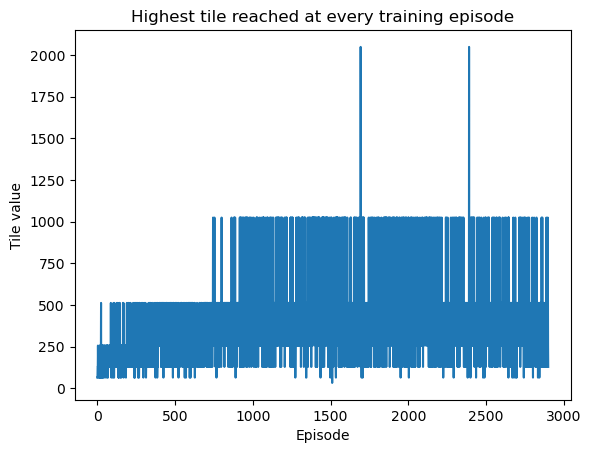

In [27]:
plt.plot(agent.train_high_history)

plt.title("Highest tile reached at every training episode")

plt.xlabel("Episode")
plt.ylabel("Tile value")

plt.show()

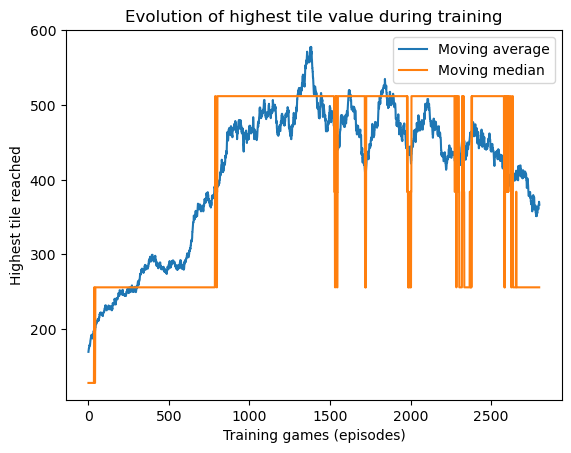

In [10]:
metric = agent.train_high_history
window_size = 100

plt.plot(moving_average(metric, window_size), label="Moving average")
plt.plot(moving_median(metric, window_size), label="Moving median")

plt.xlabel("Training games (episodes)")
plt.ylabel("Highest tile reached")

plt.title("Evolution of highest tile value during training")

plt.legend()

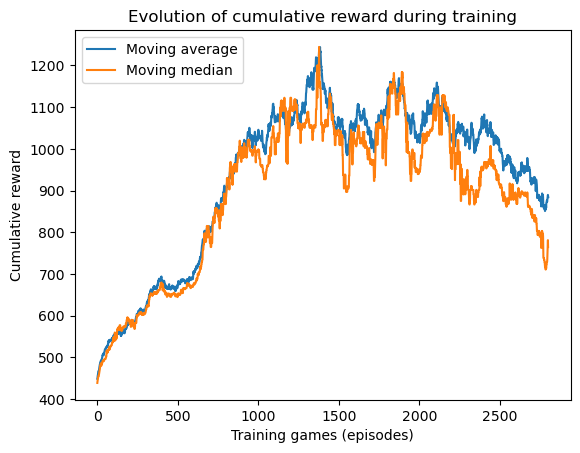

In [61]:
metric = agent.train_reward_history
window_size = 100

plt.plot(moving_average(metric, window_size), label="Moving average")
plt.plot(moving_median(metric, window_size), label="Moving median")

plt.xlabel("Training games (episodes)")
plt.ylabel("Cumulative reward")

plt.title("Evolution of cumulative reward during training")

plt.savefig("/Users/omar/Desktop/3A CS/Reinforcement Learning/Group Project/Photos/cum_reward.png")

plt.legend()

plt.show()

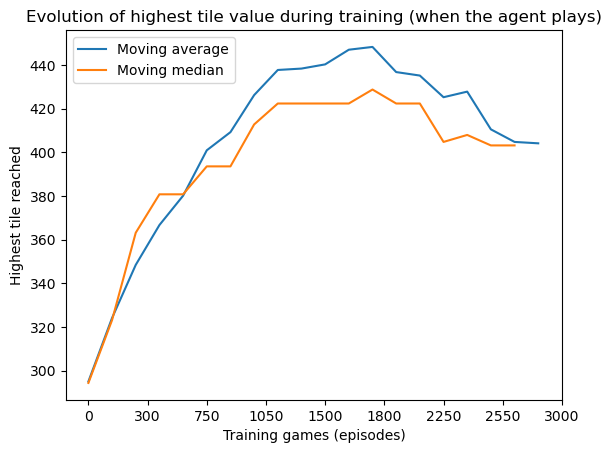

In [63]:
metric = agent.train_play_high_history
window_size = 10

plt.plot(moving_average(metric, window_size), label="Moving average")
plt.plot(moving_median(metric, window_size), label="Moving median")

plt.xlabel("Training games (episodes)")
plt.ylabel("Highest tile reached")

plt.title("Evolution of highest tile value during training (when the agent plays)")

plt.xticks(ticks=plt.xticks()[0][1:], labels=150 * np.array(plt.xticks()[0][1:], dtype=int))

plt.savefig("/Users/omar/Desktop/3A CS/Reinforcement Learning/Group Project/Photos/highest_tile_DQN_play.png")

plt.legend()

plt.show()

## Playing and testing

We load the model that we just trained

In [13]:
path_format = "soft_bs=64_gamma=0.99_lr=0.0001_eps=0.2_decay=750"
agent.load_model(path_format)

Model loaded !


We will now play several games to examine the distribution of score of the agent.

In [14]:
from collections import defaultdict

play_high_dict = defaultdict(int)
occurences = []

n_plays_test = 1000

for _ in tqdm(range(n_plays_test)):
    agent.play(False)

    highest_value = agent.play_high

    occurences.append(highest_value)

    play_high_dict[highest_value] += 1


100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [24:49<00:00,  1.49s/it]


In [15]:
play_high_dict

defaultdict(int,
            {512: 392, 256: 379, 64: 18, 1024: 114, 128: 94, 32: 2, 2048: 1})

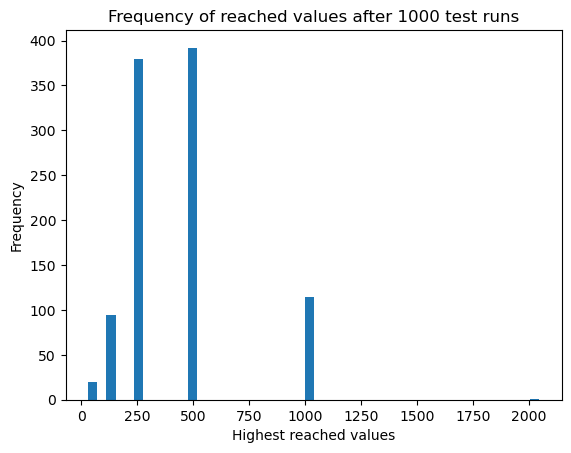

In [64]:
plt.hist(occurences, align='mid', bins=50)

plt.xlabel('Highest reached values')
plt.ylabel('Frequency')

plt.title("Frequency of reached values after 1000 test runs")
#plt.xscale('log')

plt.savefig("/Users/omar/Desktop/3A CS/Reinforcement Learning/Group Project/Photos/tile_dist.png")

plt.show()

In [17]:
agent.play()

Score: 12196.0
Highest: 1024
[[   2   64    4    8]
 [  16 1024    8  128]
 [   4   16  256   32]
 [   2   32    4    2]]


# Thank you !